In [1]:
import os
import simulation
import pynbody
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import ipywidgets
import tqdm
from simulation.sfh_in_box import sfh, plot_sfh, plot_binned_sfh
from data_pd.dump_features import dump_features
from astropy import constants as c
from astropy.table import Table

In [2]:
SIMPATH = '/home/michele/sim/MySimulations/ng'

In [3]:
SIM = 'mb.71002'
TRAJ = 'p100_a800_r600'

In [4]:
sim_path = os.path.join(SIMPATH, "{}_{}".format(SIM, TRAJ), "out")
NTH = 1
sim = simulation.Simulation(sim_path, snap_indexes=slice(None, 100, NTH))

loading simulation: /home/michele/sim/MySimulations/ng/mb.71002_p100_a800_r600/out
Found parameter file
Found compiler file
Found 563 snapshots
Taking 100 snapshots (slice(None, 100, 1))
Loading cosmological parameters
Found trace file


In [5]:
# load_cache = True
# radius = 5
# outname = 'data_pd/{}_{}_s{}_n{}.fits'.format(SIM, TRAJ, radius, NTH)
# if load_cache:
#     tbl = Table.read(outname)
# else:
#     dump_features(sim, outname, radius=radius)
#     tbl = Table.read(outname)

In [6]:
from simulation.derived import mgfe, feh, gas_metals
snap = sim[50]

In [7]:
snap.s['mass'].in_units('Msol').mean()

SimArray(8243.335, dtype=float32, 'Msol')

In [8]:
snap

<SimSnap "/home/michele/sim/MySimulations/ng/mb.71002_p100_a800_r600/out/snapshot_0051" len=360250>

In [9]:
snap.properties

{'time': Unit("8.89e+00 s kpc km**-1"),
 'h': 0.7,
 'omegaL0': 0.72,
 'omegaM0': 0.28}

In [10]:
pynbody.config['sph']['smooth-particles'] = 50

In [11]:
pynbody.analysis.halo.transformation.GenericTranslation?

Init signature: pynbody.analysis.halo.transformation.GenericTranslation(f, arname, shift)
Docstring:      <no docstring>
File:           ~/Software/miniconda3/lib/python3.6/site-packages/pynbody/transformation.py
Type:           type
Subclasses:     


In [12]:
sl = ipywidgets.IntSlider(min=0, max=len(sim)-1, value=0)
delta = 30
def k(i): 
    snap = sim[i]
    print(len(snap.g))
    
    pynbody.analysis.halo.center(snap.s)
#     with pynbody.transformation.translate(snap, shift=[-30] * 3):
    pynbody.plot.image(snap.g, qty='rho', av_z=True, width=5, log=True)#, vmin=0, vmax=0.5)#, vmin=-10.5, vmax=-1);

In [13]:
w = ipywidgets.interactive(k, i=sl)
w.children[-1].layout.height = '350px'
w

interactive(children=(IntSlider(value=0, description='i', max=99), Output(layout=Layout(height='350px'))), _do…

In [14]:
sim.properties.get('boxsize'), snap.properties.get('boxsize')

(None, None)

In [15]:
sl = ipywidgets.IntSlider(min=0, max=len(sim)-1, value=0)
def k(i): 
    snap = sim[i]
    pynbody.analysis.halo.center(snap.s)
#     pynbody.plot.image(snap.s, qty='feh', width=4, log=False, vmin=-2.5, vmax=0);
    
    pynbody.plot.image(snap.s, av_z=True, qty='fest', width=5, log=False)#, vmin=-2.5, vmax=0);
#     pynbody.plot.image(snap.s, av_z=True, qty='feh', width=4, log=False, vmin=-5, vmax=0);

In [16]:
w = ipywidgets.interactive(k, i=sl)
w.children[-1].layout.height = '280px'
w

interactive(children=(IntSlider(value=0, description='i', max=99), Output(layout=Layout(height='280px'))), _do…

In [35]:
sl = ipywidgets.IntSlider(min=0, max=len(sim)-1, value=0)
def k(i): 
    snap = sim[i]
#     pynbody.analysis.halo.center(snap.s)
    with pynbody.transformation.translate(snap, shift=[-30] * 3):
        pynbody.plot.image(snap.g, resolution=500, av_z=True, qty='gas_metals', width=100, log=True, vmin=1e-5, vmax=2e-4);


In [36]:
w = ipywidgets.interactive(k, i=sl)
w.children[-1].layout.height = '280px'
w

interactive(children=(IntSlider(value=0, description='i', max=99), Output(layout=Layout(height='280px'))), _do…

In [19]:
from simulation.luminosity import surface_brightness, color_plot

SimArray([[31.583946, 31.579037, 31.57415 , ..., 32.031612, 32.032574,
           32.033543],
          [31.567348, 31.562405, 31.557487, ..., 32.02288 , 32.023907,
           32.024933],
          [31.550999, 31.546024, 31.541077, ..., 32.01422 , 32.015305,
           32.016388],
          ...,
          [32.369675, 32.367138, 32.364605, ..., 31.59449 , 31.5923  ,
           31.590122],
          [32.370426, 32.367912, 32.365406, ..., 31.597305, 31.5952  ,
           31.593098],
          [32.371178, 32.368687, 32.366207, ..., 31.600128, 31.598103,
           31.596077]], dtype=float32, 'arcsec**-2')

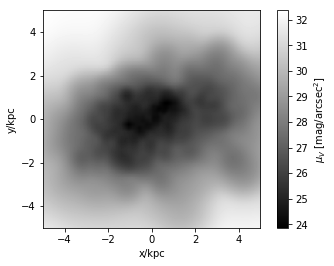

In [33]:
surface_brightness(snap, cmap_name='gray')
# pynbody.plot.image(snap.s, av_z=True, qty='fest', width=4, log=False)#, vmin=-2.5, vmax=0);

In [36]:
def adjust_cbar_range(cbar_range):
    if cbar_range is not None:
        if isinstance(cbar_range, (list, tuple) ) and len(cbar_range) == 2:
            m, M = cbar_range
        else:
            m, M = -cbar_range, cbar_range
    else:
        return None, None
    return m, M

In [82]:
def plot_maps(sb, color, fe, width, band=None, cmap_name=None,
              sb_range=None, color_range=None, sigma_range=None):
    from mpl_toolkits.axes_grid1 import AxesGrid
    fig = plt.figure(figsize=(12,4))
    grid = AxesGrid(fig, 111,  # similar to subplot(142)
                    nrows_ncols=(1, 3),
                    axes_pad=0.5,
    #                 share_x=True,
    #                 share_all=False,
                    label_mode="all",
                    cbar_mode="each",
                    cbar_location="top",
                    cbar_size="3%",
                    cbar_pad="2%"
                   )

    v_los_min, v_los_max = adjust_cbar_range(color_range)
    sigma_min, sigma_max = adjust_cbar_range(sigma_range)
    sb_min, sb_max = adjust_cbar_range(sb_range)
    if not isinstance(cmap_name, (list, tuple)):
        cmap_name = [cmap_name] * 3

    cmap = list()
    for c in cmap_name:
        cmap.append(plt.get_cmap(c))
    
    extent = (-width/2, width/2, -width/2, width/2)
    a = grid[0].imshow(sb, extent=extent, cmap=cmap[0], origin='lower', vmin=sb_min, vmax=sb_max)
    b = grid[1].imshow(color, extent=extent,cmap=cmap[1], origin='lower', vmin=v_los_min, vmax=v_los_max)
    c = grid[2].imshow(fe, extent=extent,cmap=cmap[2], origin='lower', vmin=sigma_min, vmax=sigma_max)

    grid[0].set_xlabel('x/kpc')
    grid[1].set_xlabel('x/kpc')
    grid[2].set_xlabel('x/kpc')

    grid[0].set_ylabel('y/kpc')

    cb1 = grid.cbar_axes[0].colorbar(a)
    cb1.set_label_text('$\mu_{}$'.format(band) if band is not None else '$\mu$' + ' [mag/arcsec$^2$]')

    cb2 = grid.cbar_axes[1].colorbar(b)
    cb2.set_label_text("$B-I$")

    cb3 = grid.cbar_axes[2].colorbar(c)
#     cb3.set_label_text("$[Fe/H]$")
    cb3.set_label_text("$Metals$")
    return grid

In [83]:
color = color_plot(snap, cmap_name='gray', noplot=True)
sb = surface_brightness(snap, cmap_name='gray', noplot=True)
fe = pynbody.plot.image(snap.s, av_z=True, qty='fest', width=4, log=False, noplot=True)#, vmin=-2.5, vmax=0);

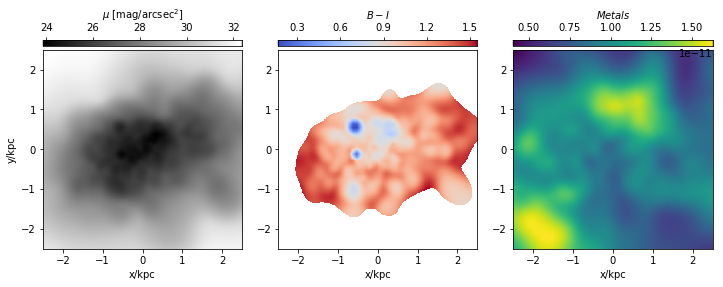

In [84]:
plot_maps(sb, color, fe, width=5, cmap_name=['gray', 'coolwarm', 'viridis'])

In [89]:
width=20
resolution=100
def k(i): 
    snap = sim[i]
    pynbody.analysis.halo.center(snap.s)
    color = color_plot(snap, noplot=True, width=width, mag_filter=None, resolution=resolution)
    sb = surface_brightness(snap, cmap_name='gray', noplot=True, width=width, resolution=resolution)
    fe = pynbody.plot.image(snap.s, av_z=True, qty='metals', width=width, log=False, noplot=True, resolution=resolution)#, vmin=-2.5, vmax=0);
    plot_maps(sb, color, fe, width=width,  cmap_name=['gray', 'coolwarm', 'viridis'])
w = ipywidgets.interactive(k, i=sl)
w.children[-1].layout.height = '280px'
w

interactive(children=(IntSlider(value=78, description='i', max=562), Output(layout=Layout(height='280px'))), _…

## Deriving functions machinery

In [64]:
fam=snap.g._unifamily

In [65]:
snap._family_derived_array_names[fam]

['mu', 'cs']

In [66]:
snap._derived_array_names

[]

In [68]:
snap.is_derived_array('p')

False

In [49]:
snap._family_derived_array_names[fam]

['mgfe']

In [70]:
snap._find_deriving_function('mgfe')

<function simulation.derived.mgfe(snap)>

In [72]:
snap._dependency_tracker.calculating

<bound method DependencyTracker.calculating of <pynbody.dependencytracker.DependencyTracker object at 0x7f7599ed1358>>

In [89]:
pynbody.family.get_family('g')

<Family gas>

In [104]:
snap._unifamily is pynbody.family.star

False